<a href="https://colab.research.google.com/github/DomTorres/oceanhacks-vic04-model/blob/main/data_ingest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
N_OCEAN_NODES = 2532
N_TIMESTAMPS = 17535

# Points are positioned on a 93 x 74 grid.
# (Currents array will have shape (N, 2, 74, 93)).
N_X = 93
N_Y = 74

In [ ]:
import os

base_dir = '/content/drive/MyDrive/coastal-radar/tuv-meta/'

data_dirs = [
    os.path.join(base_dir, '2023'),
    os.path.join(base_dir, '2024')
  ]

mat_files = []
for d in data_dirs:
    year_files = [
        os.path.join(d, f)
        for f in os.listdir(d)
        if f.endswith('.mat') and 'Totals_Clean' in f
    ]
    mat_files.extend(year_files)

mat_files = sorted(mat_files)
print(f'Found {len(mat_files)} .mat files across both years')

Found 24 .mat files across both years


In [ ]:
all_currents = []
all_timestamps = []

space_valid_counts = np.zeros((N_Y, N_X), dtype=int)
time_valid_counts = []

In [ ]:
import numpy as np
from scipy.io import loadmat

for file in mat_files:

  mat = loadmat(file)
  print(f'Processing file: {file}')

  totals = mat['Totals']
  grid = mat['Grid']

  n_timestamps = len(totals['TimeStamp'])
  print(f'Number of timestamps: {n_timestamps}')

  nodes_ocean_index = get_nodes_ocean_index()

  for t in range(n_timestamps):

      timestamp = totals['TimeStamp'][t][0][0][0]
      all_timestamps.append(timestamp)

      U = totals['U'][t,0].ravel()
      V = totals['V'][t,0].ravel()

      flags = totals['QC'][0,0]['overallFlag'][0,0].ravel()

      valid_mask = (flags == 1)
      U_valid = np.where(valid_mask, U, np.nan)
      V_valid = np.where(valid_mask, V, np.nan)

      x_idx = nodes_ocean_index[:, 0].astype(int).ravel()
      y_idx = nodes_ocean_index[:, 1].astype(int).ravel()

      grid = np.full((2, N_Y, N_X), np.nan)

      grid[0, y_idx, x_idx] = U_valid  # U component
      grid[1, y_idx, x_idx] = V_valid  # V component

      assert(
          len(U) ==
          len(V) ==
          len(flags) ==
          len(nodes_ocean_index) ==
          n_points
      ) # all 3522

      all_currents.append(grid)

      # track sparsity
      space_valid_counts[y_idx[valid_mask], x_idx[valid_mask]] += 1
      time_valid_counts.append(np.sum(valid_mask))

Streaming output truncated to the last 5000 lines.
Timestamp 144: 739410
Timestamp 145: 739410.0416666666
Timestamp 146: 739410.0833333334
Timestamp 147: 739410.125
Timestamp 148: 739410.1666666666
Timestamp 149: 739410.2083333334
Timestamp 150: 739410.25
Timestamp 151: 739410.2916666666
Timestamp 152: 739410.3333333334
Timestamp 153: 739410.375
Timestamp 154: 739410.4166666666
Timestamp 155: 739410.4583333334
Timestamp 156: 739410.5
Timestamp 157: 739410.5416666666
Timestamp 158: 739410.5833333334
Timestamp 159: 739410.625
Timestamp 160: 739410.6666666666
Timestamp 161: 739410.7083333334
Timestamp 162: 739410.75
Timestamp 163: 739410.7916666666
Timestamp 164: 739410.8333333334
Timestamp 165: 739410.875
Timestamp 166: 739410.9166666666
Timestamp 167: 739410.9583333334
Timestamp 168: 739411
Timestamp 169: 739411.0416666666
Timestamp 170: 739411.0833333334
Timestamp 171: 739411.125
Timestamp 172: 739411.1666666666
Timestamp 173: 739411.2083333334
Timestamp 174: 739411.25
Timestamp 175: 7

In [ ]:
currents = np.stack(all_currents, axis=0)  # (n_total_timestamps, 2, 74, 93)
timestamps = matlab_datenum_to_datetime(np.array(all_timestamps))
time_valid_counts = np.array(time_valid_counts)

print(f'Final shapes:')
print(f'currents: {currents.shape}')
print(f'timestamps: {timestamps.shape}')

print(f'space_valid_counts: {space_valid_counts.shape}')
print(f'time_valid_counts: {time_valid_counts.shape}')

Final shapes:
currents: (17535, 2, 74, 93)
timestamps: (17535,)
space_valid_counts: (74, 93)
time_valid_counts: (17535,)


In [ ]:
save_dir = '/content/drive/MyDrive/coastal-radar-processed/processed-data/'
os.makedirs(save_dir, exist_ok=True)

# Save each array separately (compressed)
np.savez_compressed(os.path.join(save_dir, 'currents.npz'), currents=currents)
np.savez_compressed(os.path.join(save_dir, 'timestamps.npz'), timestamps=timestamps)
np.savez_compressed(os.path.join(save_dir, 'space_valid_counts.npz'), space_valid_counts=space_valid_counts)
np.savez_compressed(os.path.join(save_dir, 'time_valid_counts.npz'), time_valid_counts=time_valid_counts)


In [ ]:
from datetime import datetime, timedelta
import numpy as np

# MATLAB datenum to datetime
def matlab_datenum_to_datetime(datenum_array):
    """
    Convert MATLAB datenum (float days since year 0) to Python datetime.
    """
    return np.array([
        datetime.fromordinal(int(d)) + timedelta(days=float(d) % 1) - timedelta(days=366)
        for d in datenum_array
    ])


In [ ]:
import numpy as np
from scipy.spatial import KDTree

def get_nodes_ocean_index():
  data_dir = '/content/drive/MyDrive/coastal-radar/tuv-meta/2023'
  file_name = 'StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20230101T000000.000Z_20230131T230000.000Z-Totals_Clean.mat'
  # any file will do, they all share the same grid and mask

  file_path = os.path.join(data_dir, file_name)
  mat = loadmat(file_path)

  grid = mat['Grid']

  nodes = grid['nodes'][0, 0]
  tree = KDTree(nodes)

  nodes_ocean = grid['nodesOcean'][0, 0]
  _, nodes_subset = tree.query(nodes_ocean)

  nodes_index = grid['nodesIndex'][0, 0]
  nodes_ocean_index = nodes_index[nodes_subset]
  assert(len(nodes_ocean_index) == N_OCEAN_NODES)

  x_indeces = nodes_index[:,0]
  y_indeces = nodes_index[:,1]

  assert(len(np.unique(x_indeces)) == N_X)
  assert(len(np.unique(y_indeces)) == N_Y)

  # Originally, the nodes don't start at (0,0).
  MIN_X, MAX_X = -46, 46
  MIN_Y, MAX_Y = -33, 40

  assert(np.min(x_indeces) == MIN_X)
  assert(np.max(x_indeces) == MAX_X)
  assert(np.min(y_indeces) == MIN_Y)
  assert(np.max(y_indeces) == MAX_Y)

  # Shift the nodes so they start at (0,0).
  nodes_ocean_index_shifted = nodes_ocean_index - np.array([MIN_X, MIN_Y])

  return nodes_ocean_index_shifted


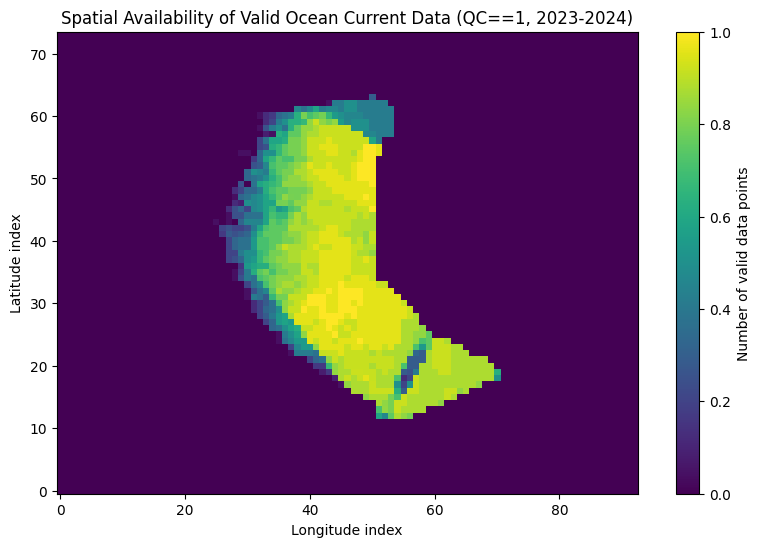

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.imshow(space_valid_counts/N_TIMESTAMPS, cmap='viridis', origin='lower')
plt.colorbar(label='Number of valid data points')
plt.title('Spatial Availability of Valid Ocean Current Data (QC==1, 2023-2024)')
plt.xlabel('Longitude index')
plt.ylabel('Latitude index')
plt.show()


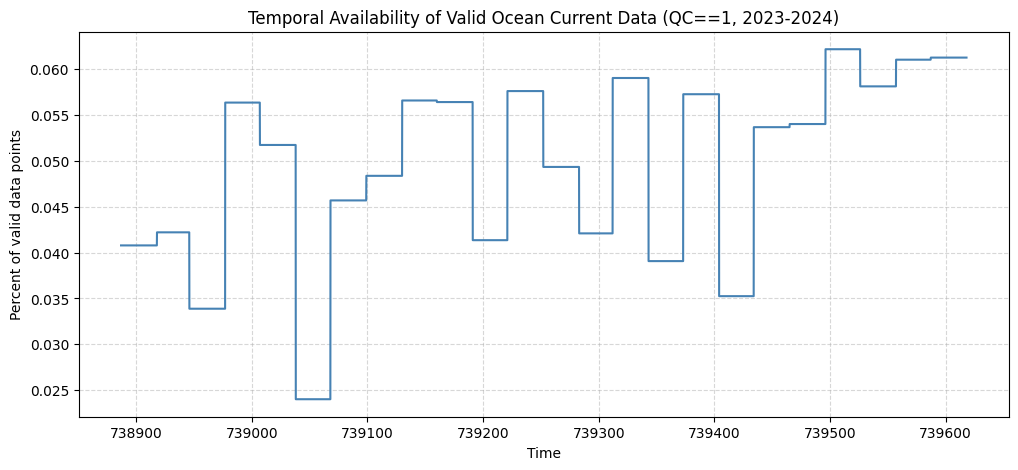

In [ ]:
# Convert timestamps to datetime if they're in seconds or string form
import matplotlib.dates as mdates

plt.figure(figsize=(12, 5))
plt.plot(timestamps, time_valid_counts/N_TIMESTAMPS, color='steelblue')
plt.title('Temporal Availability of Valid Ocean Current Data (QC==1, 2023-2024)')
plt.xlabel('Time')
plt.ylabel('Percent of valid data points')
plt.grid(True, linestyle='--', alpha=0.5)

# Improve time axis formatting (optional)
if np.issubdtype(timestamps.dtype, np.datetime64):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def plot_u_v_timeseries(currents, timestamps, y_idx, x_idx, start_time=None, end_time=None):
    """
    Plot U and V current components over time for a given spatial grid point.

    Parameters
    ----------
    currents : np.ndarray
        Shape (n_timestamps, 2, N_Y, N_X)
    timestamps : np.ndarray
        Array of datetime objects (same length as n_timestamps)
    y_idx, x_idx : int
        Coordinates of the grid point to plot
    start_time, end_time : datetime or None
        Optional range limits for the x-axis
    """
    U_series = currents[:, 0, y_idx, x_idx]
    V_series = currents[:, 1, y_idx, x_idx]

    # Apply time mask if limits are provided
    if start_time or end_time:
        mask = np.ones_like(timestamps, dtype=bool)
        if start_time:
            mask &= timestamps >= start_time
        if end_time:
            mask &= timestamps <= end_time

        timestamps = timestamps[mask]
        U_series = U_series[mask]
        V_series = V_series[mask]

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(timestamps, U_series, label="U component", lw=1)
    plt.plot(timestamps, V_series, label="V component", lw=1)
    plt.title(f"Currents over time at grid point (x={x_idx}, y={y_idx})")
    plt.xlabel("Time")
    plt.ylabel("Velocity (m/s)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


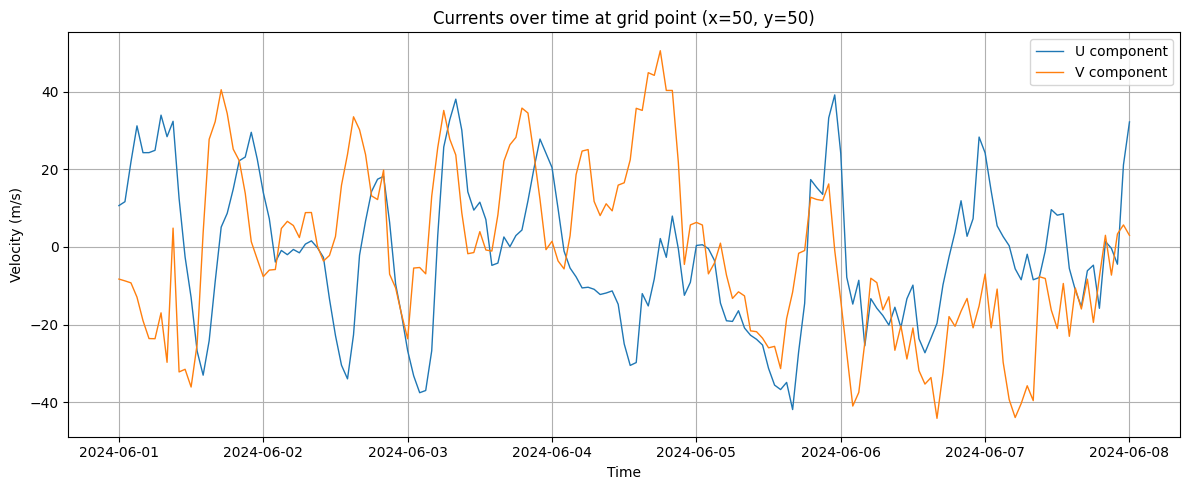

In [ ]:
# Pick a grid point (for example, y=40, x=60)
y_idx, x_idx = 50, 50

# Define a time range
start_time = datetime(2024, 6, 1)
end_time = datetime(2024, 6, 8)

# Plot
plot_u_v_timeseries(currents, timestamps, y_idx, x_idx, start_time, end_time)
